In [1]:
import scipy as sp
from scipy import optimize
import numpy as np
from numpy import array
from scipy import linalg
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from dateutil.parser import parse
import pymongo, jieba, datetime, re, json
import pandas as pd 
from datetime import timedelta


# tau=0.045
def fourier_func(x,*a):
    ret = a[0]
    w=a[1]
    start = 2
    if len(a) % 2 ==1:
        start = 1
    for deg in range(start,len(a),2):
        ret+=a[deg]*np.cos(deg*w*x)+a[deg+1]*np.sin(deg*w*x)
    return ret

def analyze(content,key):
    m={}
    for i in content:
        d = parse(i['datetime'])
        c = i['content']
#         m[d] = m.get(d,0)+len(re.findall(string=c,pattern=key))
        have = 0
        if len(re.findall(string=c,pattern=key)) > 0: 
            have = 1
        m[d] = m.get(d,0)+have
    return Series(m)

def change_index(s1,s3,start=0,end=-1):
    '''
    s1:原始数据
    s3:拟合曲线
    start:s3拟合原始数据的开始
    end:s3拟合原始数据的结束
    '''
    start_date = s1.index[start]
    end_date = s1.index[end]
    length = len(s3.index)
    
    curve_date = pd.date_range(start=start_date,end=pd.date_range(end_date,periods=4,freq='Q-JAN')[-1],periods=length)
    s3.index = curve_date
    
def curve(key_word='无',n=10,start=0,end=-1,freq='Q-JAN',curve_func=fourier_func,predict=True,
          col=pymongo.MongoClient('localhost')['scrapy']['predict'],
         src_col = pymongo.MongoClient('localhost')['scrapy']['HypebeastItem']):
    '''
    给出数据，进行拟合，并进行显示和保存
    key_word:拟合关键词
    n:傅里叶级数的阶数
    start:拟合数据的开始
    end:拟合数据的阶数
    freq:周期
    curve_func:用于拟合的函数
    predict:是否显示预测线
    col:用于保存的MongoDB
    src_col:原始数据
    '''
    cursor = src_col.find()
    out = analyze(cursor,key_word)
    sm = out.resample(freq).sum()
    smr = Series(data = sm.data,index=[x for x in range(0,len(sm.index))])
    x_data = smr.index[start:end]
    y_data = smr.data[start:end]
    func = fourier_func
    params, params_convariance = optimize.curve_fit(func, x_data, y_data,[1.0]*n)
    print(params)
    plt.plot(x_data,y_data,marker='o',color='g',
            label='data')


    plt.plot(x_data,func(x_data,*params),color='red',
            label='fit_curved')

    x_temp = np.linspace(x_data[0],x_data[-1]+4,100)

    if predict:
        plt.plot(x_temp,func(x_temp,*params),'b--',label='real_fit_curved')


    plt.title(key_word)
    plt.legend()
    plt.show()
    #     保存数据
    s3= Series(func(x_temp,*params),x_temp)
    
    change_index(sm,s3,start,end)
    
    
    df1 = DataFrame({'data':sm})
    df2 = DataFrame({'curve':s3})
    
    df3 = df1.add(df2,fill_value=0)
    
    df3.plot()
    
    j = json.loads(df3.to_json(orient='split',date_unit='s'))

    j['key'] = key_word
    j['freq'] = freq
    
#     col.insert_one(j)
    col.update_one({"key":j['key'],"freq":j['freq']},{"$set":j},upsert=True)
    



In [2]:
s = pd.read_json('value',typ='series')
ss = s[1:-1]

In [3]:
with tf.Session() as sess:
    print(sess.run(tf.random_normal()))

NameError: name 'tf' is not defined

In [4]:
import random

In [5]:
random.random()

0.5604201054335707

In [6]:
t = ss.index.timestamp()

AttributeError: 'DatetimeIndex' object has no attribute 'timestamp'

In [7]:
i = ss.index[0].date()
str(i).split('-')

['2015', '07', '31']

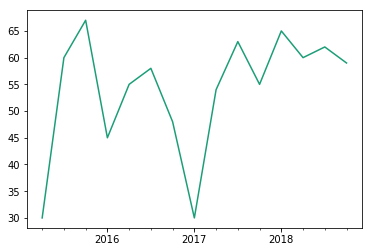

In [8]:
s.index[0]
s.plot(colormap='Dark2')

In [9]:
date = pd.date_range(s.index[0],periods=18,freq='Q-JAN')

In [10]:
[decompose_num(str(x.date()).split('-')) for x in pd.date_range(s.index[0],periods=18,freq='Q-JAN')]

NameError: name 'decompose_num' is not defined

In [11]:
def decompose_num(nums):
    '''
    如：nums=['2015', '07', '31']
    '''
    a=[]
    for num in nums:
        for j in num:
            a.append(int(j))
    return a
decompose_num(['2015', '07', '31'])

[2, 0, 1, 5, 0, 7, 3, 1]

8
After 0 training step(s), MSE on all data is 11663.3
After 1000 training step(s), MSE on all data is 3100.1
After 2000 training step(s), MSE on all data is 870.71
After 3000 training step(s), MSE on all data is 242.75
After 4000 training step(s), MSE on all data is 112.079
After 5000 training step(s), MSE on all data is 73.2403
After 6000 training step(s), MSE on all data is 54.4786
After 7000 training step(s), MSE on all data is 39.8665
After 8000 training step(s), MSE on all data is 28.9279


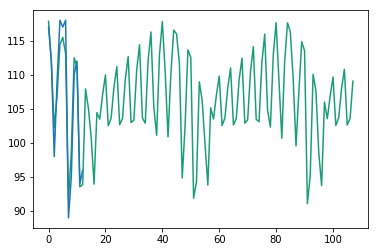

In [47]:
import tensorflow as tf
import random

# 正则化损失函数系数
REGULARIZATION_RATE = 0.2
HIDDEN_LAYER=50
OUTPUT_NODE=1
FREQ='Q-JAN'
KEYWORD='绿'

# 清空图
tf.reset_default_graph()

# 数据
col = pymongo.MongoClient('localhost')['scrapy']['HypebeastItem']
cursor = col.find()
s = analyze(cursor,KEYWORD)
s = s.resample(FREQ).sum()
ss = s[1:-1]

X=[decompose_num(str(t.date()).split('-')) for t in ss.index]
Y = [[t] for t in ss]

input_node=len(X[0])
print(input_node)

# 模型 

w1 = tf.Variable(tf.random_normal([input_node,HIDDEN_LAYER]))
w2 = tf.Variable(tf.random_normal([HIDDEN_LAYER,HIDDEN_LAYER]))
w3 = tf.Variable(tf.random_normal([HIDDEN_LAYER,OUTPUT_NODE]))

biases1 = tf.Variable(tf.constant(0.1,shape=[HIDDEN_LAYER]))
biases2 = tf.Variable(tf.constant(0.1,shape=[HIDDEN_LAYER]))
biases3 = tf.Variable(tf.constant(0.1,shape=[OUTPUT_NODE]))


x = tf.placeholder(tf.float32,shape=(None,input_node),name='x-input')
y_ = tf.placeholder(tf.float32,shape=(None,1),name='y-input')

a1 = tf.nn.sigmoid(tf.matmul(x,w1) + biases1)
a2 = tf.nn.sigmoid(tf.matmul(a1,w2) + biases2)
y = tf.nn.relu(tf.matmul(a2,w3) + biases3)

# a = tf.matmul(x,w1) + biases1
# y = tf.matmul(a,w2) + biases2

# 计算L2正则化损失函数
regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
# 计算模型正则化损失。一般只计算权重，而不用偏置值
regularization = regularizer(w1)+regularizer(w2)

# 定义mse
mse = tf.reduce_mean(tf.square(y_ - y))

# 定义损失函数
# y_为标准答案
# loss = mse
loss = mse + regularization
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)


# 测试数据
test_x = [decompose_num(str(x.date()).split('-')) for x in pd.date_range(ss.index[0],periods=input_node+100,freq='Q-JAN')]
test_y = None

with tf.Session() as sess:
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    STEPS = 8001
    for i in range(STEPS):
        if i % 1000 == 0:
            print("After %d training step(s), MSE on all data is %g" % (i,sess.run(loss,feed_dict={x:X,y_:Y})))
        sess.run(train_step,feed_dict={x:X,y_:Y})
#     print(sess.run(w1))
#     print(sess.run(w2))
#   测试结果
    test_feed={x:test_x}
    test_y = sess.run(y,feed_dict=test_feed)
#     print(test_y)
    test_y_s=Series([x[0] for x in test_y])
    test_y_s.plot(colormap='Dark2')
    ss.index =[ x for x in range(len(ss))]
#     print(out)
    ss.plot()
#     s.plot()

    writer = tf.summary.FileWriter('log',sess.graph)
#     writer.close()
    

In [13]:
test_index = [str(x[0])+'-'+str(x[1]) for x in test_x]
test_data = [x[0] for x in test_y]
test_s = Series(test_data,index=test_index)

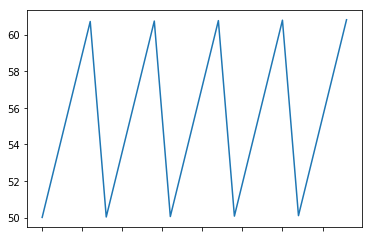

In [14]:
ss

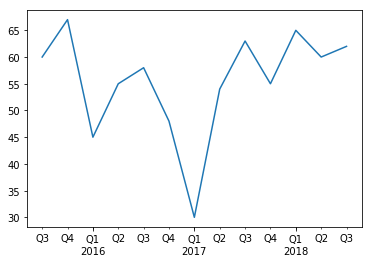

In [6]:
ss.plot()